# Setup

## Imports

In [ ]:
!pip install transformers
!pip install datasets
!pip install sacrebleu
!pip install -U nltk
!pip install rouge_score
!pip install tensorboard

     |████████████████████████████████| 3.4 MB 11.9 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 39.7 MB/s 
     |████████████████████████████████| 895 kB 35.5 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 306 kB 11.6 MB/s 
     |████████████████████████████████| 132 kB 51.9 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
     |████████████████████████████████| 243 kB 36.5 MB/s 
     |████████████████████████████████| 192 kB 49.0 MB/s 
     |████████████████████████████████| 271 kB 48.1 MB/s 
     |████████████████████████████████| 160 kB 53.2 MB/s 
     |████████████████████████████████| 90 kB 6.3 MB/s 
     |████████████████████████████████| 1.5 MB 12.2 MB/s 
     |████████████████████████████████| 749

In [2]:
import h5py, os, json, pathlib, io, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from tqdm import tqdm
from PIL import Image
from matplotlib import rcParams
from datasets import load_metric
from torch.utils.data import Dataset
from collections.abc import Callable
from torchvision import transforms as T
from transformers.models.beit.modeling_beit import *
from transformers import (GPT2Model, BertModel, BertTokenizerFast, GPT2TokenizerFast, ViTModel, ViTFeatureExtractor, VisionEncoderDecoderConfig, VisionEncoderDecoderModel,
                          BeitFeatureExtractor, Seq2SeqTrainer, Seq2SeqTrainingArguments)
from torch.utils.tensorboard import SummaryWriter

## Data & model paths

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# MAIN PATHS
drive_path = 'drive/MyDrive/Tesi/'
data_path = drive_path + 'dataset/'
checkpoints_path = drive_path + 'checkpoints/'
module_path = drive_path.replace('/', '.') + 'modules.'

# modules saved on drive
CustomTrainer = importlib.import_module(module_path + 'custom_trainer').CustomTrainer
CustomBeitModel = importlib.import_module(module_path + 'custom_beit_model').CustomBeitModel
Product = importlib.import_module(module_path + 'fashiongen_utils').Product
FashionGenDataset = importlib.import_module(module_path + 'fashiongen_utils').FashionGenDataset

In [5]:
# class to hold components of Encoder-Decoder model
class modelComponents():
  def __init__(self, encoder, encoder_checkpoint, decoder, decoder_checkpoint, img_processor, tokenizer):
    self.encoder_checkpoint = encoder_checkpoint
    self.decoder_checkpoint = decoder_checkpoint
    self.img_processor = img_processor
    self.tokenizer = tokenizer
    self.encoder = encoder
    self.decoder = decoder

In [6]:
# component configurations
vit_bert = modelComponents(encoder=ViTModel, encoder_checkpoint='google/vit-base-patch16-224-in21k',
                           decoder=BertModel, decoder_checkpoint='bert-base-uncased',
                           img_processor=ViTFeatureExtractor, tokenizer=BertTokenizerFast)

vit_gpt2 = modelComponents(encoder=ViTModel, encoder_checkpoint='google/vit-base-patch16-224-in21k',
                           decoder=GPT2Model, decoder_checkpoint='gpt2',
                           img_processor=ViTFeatureExtractor, tokenizer=GPT2TokenizerFast)

beit_gpt2 = modelComponents(encoder=CustomBeitModel, encoder_checkpoint='microsoft/beit-base-patch16-224-pt22k',
                           decoder=GPT2Model, decoder_checkpoint='gpt2',
                           img_processor=BeitFeatureExtractor, tokenizer=GPT2TokenizerFast)

## Device & Batch size

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

# Model and Data setup

## Dataset class

In [8]:
fashiongen_train = FashionGenDataset(data_path + "fashiongen_256_256_train.h5")

class FashionGenTorchDataset(torch.utils.data.Dataset):
    def __init__(self, file_name, caption_encodings, img_processor, n_samples:int, subcategory:bool=False):
        self.n_samples = n_samples
        self.file_path = file_name
        self.dataset = h5py.File(file_name, mode='r')["input_image"]
        self.caption_encodings = caption_encodings
        self.img_processor = img_processor
        self.subcategory = subcategory
        if(self.n_samples == -1): self.n_samples = len(self.dataset)
        else: assert n_samples <= len(self.dataset), 'n_samples must be <=' + str(len(self.dataset))

    def __getitem__(self, idx):
        return {"pixel_values":self.preprocess_image(self.dataset[idx]),
                "labels":self.caption_encodings[idx],
                "negative":self.get_product_same_category(idx)}

    def set_subcategory(self, subcategory:bool):
        self.subcategory = subcategory

    def __len__(self):
        return self.n_samples

    def preprocess_image(self, image):
        return self.img_processor(image, return_tensors="pt")['pixel_values'][0]

    def get_product_same_category(self, index:int):
        product = fashiongen_train.get_product(index)
        if self.subcategory:
          product.subcategory = product.subcategory.encode("ISO-8859-9")
          similiar = fashiongen_train.get_same_subcategory_of(product)[0].image
        else :
          product.category = product.category.encode("ISO-8859-9")
          similiar = fashiongen_train.get_same_category_of(product)[0].image
        return self.preprocess_image(similiar).to(device)

## Model and Dataset init

In [9]:
def load_data(tokenizer, img_processor, n_train, n_val, subcategory:bool=False):
  cap_train = list()
  for p in tqdm(FashionGenDataset(data_path + "fashiongen_256_256_train.h5").raw_h5()["input_description"], position=0, leave=True):
      cap_train.append(p[0].decode("ISO-8859-9")) #DEFUALT_STRINGS_ENCODING = "ISO-8859-9")

  cap_val = list()
  for p in tqdm(FashionGenDataset(data_path + "fashiongen_256_256_validation.h5").raw_h5()["input_description"], position=0, leave=True):
      cap_val.append(p[0].decode("ISO-8859-9")) #DEFUALT_STRINGS_ENCODING = "ISO-8859-9")

  # append all captions in a single shallow list, tokenize everything
  tokenizer.padding_side = "left"
  tokenizer.pad_token = tokenizer.eos_token
  cap = list(map(lambda caption: tokenizer.encode(caption.replace('<br>', ' '), return_tensors="pt", max_length=64, pad_to_max_length=True, truncation=True)[0], cap_train + cap_val))

  # split into train and validation again
  cap_train = cap[0:len(cap_train)]
  cap_val = cap[len(cap_train):]

  # create datasets
  data_train = FashionGenTorchDataset(data_path + "fashiongen_256_256_train.h5", cap_train, img_processor, n_samples=n_train, subcategory=subcategory)
  data_val = FashionGenTorchDataset(data_path + "fashiongen_256_256_validation.h5", cap_val, img_processor, n_samples=n_val, subcategory=subcategory)
  
  return data_train, data_val

def init_model_and_data(component_config:modelComponents, n_train:int=-1, n_val:int=-1, checkpoint:str=None, init_data:bool=True, subcategory:bool=False):
  # load models and their configs from pretrained checkpoints
  if(checkpoint is None):
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(component_config.encoder_checkpoint, component_config.decoder_checkpoint)
  else:
    model = VisionEncoderDecoderModel.from_pretrained(checkpoint)

  if(component_config.encoder == CustomBeitModel):
    model.encoder = CustomBeitModel.from_pretrained(component_config.encoder_checkpoint)

  # set decoder config to causal lm
  model.config.decoder_is_decoder = True
  model.config.decoder_add_cross_attention = True

  # set img_processor & tokenizer
  img_processor = component_config.img_processor.from_pretrained(component_config.encoder_checkpoint)
  tokenizer = component_config.tokenizer.from_pretrained(component_config.decoder_checkpoint)

  # decoder-specific config
  if(component_config.decoder == BertModel):
    model.config.decoder_start_token_id = tokenizer.cls_token_id
    model.config.decoder_bos_token_id = tokenizer.cls_token_id
    model.config.decoder_eos_token_id = tokenizer.sep_token_id
  else:
    model.config.decoder_start_token_id = tokenizer.bos_token_id
    model.config.decoder_bos_token_id = tokenizer.bos_token_id
    model.config.decoder_eos_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token

  model.config.pad_token_id = tokenizer.pad_token_id
  model.decoder.config.pad_token_id = tokenizer.pad_token_id
  model.config.encoder.pad_token_id = tokenizer.pad_token_id

  # generation arguments
  model.config.decoder.repetition_penalty = 10.0
  model.config.decoder.no_repeat_ngram_size = None
  model.config.decoder_start_token_id = tokenizer.bos_token_id
  model.config.decoder.eos_token_id = tokenizer.eos_token_id
  model.config.decoder.do_sample = False
  model.config.decoder.max_length = 64

  # load and prepare data
  if(init_data):
    data_train, data_val = load_data(tokenizer, img_processor, n_train, n_val, subcategory)
    return model, tokenizer, data_train, data_val
  else:
    return model, tokenizer

## Generate captions

In [10]:
def generate_caption(model, pixel_values, num_beams:int=3, do_sample:bool=False, top_p:float=1.0, top_k:int=50, repetition_penalty:float=10.0, max_length:int=64, temperature:int=1.0):
    return model.generate(pixel_values,
                          num_beams=num_beams,
                          repetition_penalty=repetition_penalty,
                          #no_repeat_ngram_size=3,
                          decoder_start_token_id=tokenizer.bos_token_id,
                          pad_token_id=tokenizer.pad_token_id,
                          eos_token_id=tokenizer.eos_token_id,
                          do_sample=do_sample,
                          temperature=temperature,
                          top_k=top_k,
                          top_p=top_p,
                          max_length=max_length,
                          #bad_words_ids=[tokenizer.eos_token_id]
                          )

## Evaluation metrics

In [11]:
# Bleu
bleu_metric = load_metric('sacrebleu')
meteor_metric = load_metric('meteor')
rouge_metric = load_metric('rouge')

def compute_metrics(eval_preds, decode:bool=True):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    if(decode):
      preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
      # Replace -100 in the labels as we can't decode them.
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
      labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # meteor
    meteor = meteor_metric.compute(predictions=preds, references=labels)

    # rougeL
    rouge = rouge_metric.compute(predictions=preds, references=labels)

    #split into list of tokens and remove spaces
    preds = [pred.split(' ') for pred in preds]
    labels = [[label.split(' ')] for label in labels]

    # bleu
    bleu = bleu_metric.compute(predictions=preds, references=labels)
    
    result = {"bleu": bleu["score"], "meteor": meteor['meteor']*100, "rougeL": rouge['rougeL'][1][2]*100}

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    # result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result


Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

## Max decoder input size

In [12]:
def get_decoder_input_size(model, data_train):
  max_decoder_input_size = model.config.decoder.max_position_embeddings
  decoder_input_size = len(data_train[0]['labels'])
  return {'decoder_input_size':decoder_input_size, 'max_decoder_input_size':max_decoder_input_size}

# Training

## VitGpt2

### Init

In [ ]:
# n_train = -1 uses full dataset
model, tokenizer, data_train, data_val = init_model_and_data(vit_gpt2, n_train=-1, n_val=4000)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.2.crossattention.bias', 'h.3.crossattention.c_attn.weight', 'h.3.ln_cross_attn.weight', 'h.11.crossattention.c_proj.bias', 'h.3.crossattention.bias', 'h.2.crossattention.c_proj.weight', 'h.1.crossattention.c_proj.weight', 'h.11.crossattention.c_proj.weight', 'h.5.crossattention.c_proj.weight', 'h.5.crossattention.bias', 'h.3.crossattention.masked_bias', 'h.5.ln_cross_attn.weight', 'h.7.crossattention.q_attn.weight', 'h.8.crossattention.c_attn.weight', 'h.7.crossattention.bias', 'h.1.crossattention.q_attn.weight', 'h.11.crossattention.q_attn.weight', 'h.6.crossattention.masked_bias', 'h.0.crossattention.bias', 'h.7.ln_cross_attn.weight', 'h.8.crossattention.masked_bias', 'h.9.crossattention.c_proj.bias', 'h.9.crossattention.bias', 'h.8.crossattention.c_proj.bias', 'h.4.crossattention.c_attn.weight', 'h.1.crossattention.bias', 'h.0.crossattention.q_attn.weight', 'h.6.cros

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

100%|██████████| 32528/32528 [00:41<00:00, 788.85it/s] 
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Trainer class

In [ ]:
training_args = Seq2SeqTrainingArguments(
    dataloader_pin_memory = not device.type == 'cuda',
    per_device_train_batch_size = batch_size,   # batch size per device during training
    per_device_eval_batch_size = batch_size,    # batch size for evaluation
    output_dir = checkpoints_path,    # output directory
    overwrite_output_dir = False,
    load_best_model_at_end = False,
    predict_with_generate = True,
    generation_num_beams = 3, 
    eval_accumulation_steps = 250,  # send logits and labels to cpu for evaluation step by step, rather than all together
    evaluation_strategy ='steps',
    save_strategy = 'steps',
    # save_total_limit = 1,   # Only last [save_total_limit] models are saved. Older ones are deleted.
    save_steps = 1000,
    eval_steps = 1000,    # Evaluation and Save happens every [eval_steps] steps
    learning_rate = 5e-5,
    num_train_epochs = 1,    # total number of training epochs
    warmup_steps = 500,   # number of warmup steps for learning rate scheduler
    weight_decay = 0.01    # strength of weight decay
)

trainer = CustomTrainer(
    compute_metrics = compute_metrics,
    tokenizer = None,
    data_collator = None,
    model = model, # the instantiated 🤗 Transformers model to be trained
    args = training_args,   # training arguments, defined above
    train_dataset = data_train,   # training dataset
    eval_dataset = data_val   # evaluation dataset
)

### Training sessions

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16281
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
1000,1.174500,1.309948,11.498500,21.968200,30.379800
2000,0.977600,1.177853,10.994100,21.823900,31.338700


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: U

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-2000')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-2000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16281
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 2000
  Will skip the first 0 epochs then the first 2000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
3000,0.885600,1.115892,12.936000,25.858500,36.718400
4000,0.858800,1.077685,12.980100,25.178500,36.344300


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: U

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-4000')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-4000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16281
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 4000
  Will skip the first 0 epochs then the first 4000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
5000,0.815400,1.047522,13.161400,26.235100,37.506100
6000,0.785200,1.028187,13.586300,26.516800,38.014200


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: U

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-6000')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-6000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16281
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 6000
  Will skip the first 0 epochs then the first 6000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/6000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
7000,0.783000,1.013959,13.267400,26.178500,37.447000


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-7000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
7000,0.783000,1.013959,13.267400,26.178500,37.447000
8000,0.758400,1.005009,13.774200,26.534200,38.250000


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-8000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-8000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-8000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


In [ ]:
trainer.train(checkpoints_path + 'checkpoint-8000')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-8000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16281
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 8000
  Will skip the first 0 epochs then the first 8000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/8000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
9000,0.750100,0.992250,12.948800,25.725800,37.458600
10000,0.732600,0.982352,14.147900,27.194600,38.988300


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-9000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-10000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384

In [ ]:
# da qui ho settato do_sample=true
trainer.train(checkpoints_path + 'VitGpt2-fashiongen-checkpoint-10000')

Loading model from drive/MyDrive/Tesi/checkpoints/VitGpt2-fashiongen-checkpoint-10000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16281
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 10000
  Will skip the first 0 epochs then the first 10000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
11000,0.729800,0.976265,41.301900,46.291300,45.144900


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:2142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-11000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-11000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-11000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be compu

# Evaluation

## Train data samples

In [ ]:
def show_train_data_sample():
  data_train = FashionGenDataset(data_path + "fashiongen_256_256_train.h5")
  data_val = FashionGenDataset(data_path + "fashiongen_256_256_validation.h5")
  pid_dict = data_train.productID_dict()

  product_id, indices = list(pid_dict.items())[91]
  fig, axs = plt.subplots(1, len(indices), figsize=(18,18))
  for j, idx in enumerate(indices):
    product = data_train.get_product(idx)
    axs[j].imshow(product.image)

  print(product)

Creating productID dictionary...


100%|██████████| 260490/260490 [05:12<00:00, 832.73it/s] 


name: Navy Skull Jacquard Windbreaker
caption: Hooded windbreaker in navy sheen. Tonal jacquard skull print throughout. Zip closure at front. Zippered welt pockets at waist. Bungee drawstring at hood and hem. Ribbed knit sleeve cuffs in deep navy. Tonal partial mesh lining. Tonal stitching.
concat_caption: Hooded windbreaker in navy sheen. Tonal jacquard skull print throughout. Zip closure at front. Zippered welt pockets at waist. Bungee drawstring at hood and hem. Ribbed knit sleeve cuffs in deep navy. Tonal partial mesh lining. Tonal stitching. Short sleeve shirt in white. Drop graphic print throughout in black. Spread collar. Button closure at front. Tonal stitching.
category: JACKETS & COATS
subcategory: JACKETS
composition: Body: 100% polyamide. Partial lining: cotton.
department: CLOTHING
gender: Men
msrpUSD: 990.0
season: SS2014
brand: Alexander McQueen
pose: id_gridfs_4


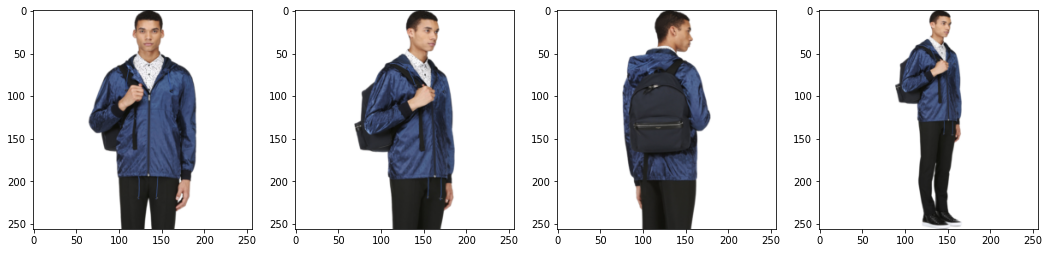

In [ ]:
show_train_data_sample()

## Metrics on validation dataset

In [ ]:
checkpoint = checkpoints_path + 'VitGpt2-fashiongen-checkpoint-11000'
model, tokenizer, data_train, data_val = init_model_and_data(vit_gpt2, n_train=-1, n_val=10000, checkpoint=checkpoint)

training_args = Seq2SeqTrainingArguments(
    dataloader_pin_memory = not device.type == 'cuda',
    per_device_train_batch_size = batch_size,   # batch size per device during training
    per_device_eval_batch_size = batch_size,    # batch size for evaluation
    output_dir = checkpoints_path,    # output directory
    overwrite_output_dir = False,
    load_best_model_at_end = False,
    predict_with_generate = True,
    generation_num_beams = 3, 
    eval_accumulation_steps = 250,  # send logits and labels to cpu for evaluation step by step, rather than all together
    evaluation_strategy ='steps',
    save_strategy = 'steps',
    # save_total_limit = 1,   # Only last [save_total_limit] models are saved. Older ones are deleted.
    ignore_data_skip = True,
    save_steps = 1000,
    eval_steps = 1,    # Evaluation and Save happens every [eval_steps] steps
    learning_rate = 5e-5,
    num_train_epochs = 1,    # total number of training epochs
    warmup_steps = 500,   # number of warmup steps for learning rate scheduler
    weight_decay = 0.01   # strength of weight decay
)

trainer = CustomTrainer(
    compute_metrics = compute_metrics,
    tokenizer = None,
    data_collator = None,
    model = model, # the instantiated 🤗 Transformers model to be trained
    args = training_args,   # training arguments, defined above
    train_dataset = data_train,   # training dataset
    eval_dataset = data_val   # evaluation dataset
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16281
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:2142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
1,No log,0.875787,43.121900,48.684100,48.235100


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16


KeyboardInterrupt: ignored

## Score by category

In [ ]:
def generate_predictions(model, do_sample:bool=False):
  for i in tqdm(range(0, len(data_val), 1000)):
    predicted = list()
    for k in range(i, i+1000, batch_size):
      batch = np.empty((batch_size, 3, 224, 224))
      l = 0
      for j in range(k, k+batch_size):
        batch[l] = data_val[j]['pixel_values']
        l+=1
      batch = torch.tensor(batch, device=device, dtype=torch.float)
      predicted.append(generate_caption(model, batch, do_sample=do_sample))
    predicted = np.asarray(predicted)
    # save to disk
    with open(drive_path + 'predictions/swap/predictions' + str(i) + '.npy', 'wb') as file:
      np.save(file, predicted)

In [ ]:
generate_predictions(model)

  0%|          | 0/10 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 10/10 [3:14:27<00:00, 1166.76s/it]


In [ ]:
def load_predictions(load_metrics:bool=False):
  # PREDICTIONS
  predicted = list()
  for i in range(0, len(data_val), 1000):
    with open(drive_path + 'predictions/predictions' + str(i) + '.npy', 'rb') as file:
      predicted.append(np.load(file, allow_pickle=True)) 
  predicted = [item for sublist in predicted for item in sublist]
  predicted = pd.Series(map(lambda cap: tokenizer.decode(cap, skip_special_tokens=True), predicted))
  # REAL CAPTIONS
  cap_val = list()
  for p in tqdm(FashionGenDataset(data_path + "fashiongen_256_256_validation.h5").raw_h5()["input_description"], position=0, leave=True):
      cap_val.append(p[0].decode("ISO-8859-9")) #DEFUALT_STRINGS_ENCODING = "ISO-8859-9")
  cap_val = cap_val[0:len(data_val)]
  # CATEGORIES
  cat_val = list()
  for p in tqdm(FashionGenDataset(data_path + "fashiongen_256_256_validation.h5").raw_h5()["input_category"], position=0, leave=True):
      cat_val.append(p[0].decode("ISO-8859-9")) #DEFUALT_STRINGS_ENCODING = "ISO-8859-9")
  cat_val = pd.Series(cat_val[0:len(data_val)])
  # DATAFRAME
  data = pd.DataFrame({'caption':predicted, 'category':cat_val})
  # METRICS
  if(load_metrics):
    with open(data_path + 'scores.npy', 'rb') as file:
      scores = np.load(file, allow_pickle=True)
  else:
    scores = list()
    for i in tqdm(range(0, len(data.caption.values))):
      score = compute_metrics([[data.caption.values[i]], [cap_val[i]]], decode=False)
      avg_score = sum(score.values()) / len(score)
      scores.append(avg_score)
    with open(data_path + 'scores.npy', 'wb') as file:
      np.save(file, scores)
  # RETURN FINAL DATASET
  data['score'] = scores
  data['real'] = cap_val
  return data

In [ ]:
pred_data = load_predictions(load_metrics=True)
pd.DataFrame({
    'Average Score':pred_data.score.groupby(pred_data.category.values).mean(),
    'Number of Samples':pred_data.category.value_counts()
    }).sort_values(by='Average Score', ascending=False)

,Average Score,Number of Samples
SHIRTS,54.143668,729
TOPS,48.880537,2255
JEANS,48.307670,636
SWEATERS,48.279548,1855
SUITS & BLAZERS,44.482382,209
JACKETS & COATS,44.120291,1546
PANTS,43.095065,1193
SHORTS,43.056698,444
DRESSES,41.780161,446
HATS,38.700864,167


In [ ]:
pd.DataFrame({
    'Average Score':pred_data.score.groupby(pred_data.category.values).mean(),
    'Number of Samples':pred_data.category.value_counts()
    }).sort_values(by='Number of Samples', ascending=False)

,Average Score,Number of Samples
TOPS,48.880537,2255
SWEATERS,48.279548,1855
JACKETS & COATS,44.120291,1546
PANTS,43.095065,1193
SHIRTS,54.143668,729
JEANS,48.307670,636
DRESSES,41.780161,446
SHORTS,43.056698,444
SKIRTS,37.905237,387
SUITS & BLAZERS,44.482382,209


## Evaluation on image sample

In [ ]:
checkpoint = checkpoints_path + 'swap-checkpoint-1000'
model, tokenizer, data_train, data_val = init_model_and_data(vit_gpt2, n_train=-1, n_val=-1, checkpoint=checkpoint)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

100%|██████████| 32528/32528 [00:38<00:00, 842.35it/s] 
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
img_val = h5py.File(data_path + "fashiongen_256_256_validation.h5", mode='r')["input_image"]

In [ ]:
def test_on_data_sample(index:int):
  real = data_val[index]['labels']
  real_decoded = tokenizer.decode(real, skip_special_tokens=True)

  predicted_greedy = generate_caption(data_val[index]['pixel_values'], num_beams=None, do_sample=False)
  predicted_greedy_decoded = tokenizer.decode(predicted_greedy, skip_special_tokens=True)

  predicted_beam = generate_caption(data_val[index]['pixel_values'], do_sample=False)
  predicted_beam_decoded = tokenizer.decode(predicted_beam, skip_special_tokens=True)

  predicted_sampling = generate_caption(data_val[index]['pixel_values'], temperature=0.7)
  predicted_sampling_decoded = tokenizer.decode(predicted_sampling, skip_special_tokens=True)

  metrics_greedy = compute_metrics([torch.unsqueeze(predicted_greedy, 0).cpu(), torch.unsqueeze(real, 0).cpu()])
  metrics_beam = compute_metrics([torch.unsqueeze(predicted_beam, 0).cpu(), torch.unsqueeze(real, 0).cpu()])
  metrics_sampling = compute_metrics([torch.unsqueeze(predicted_sampling, 0).cpu(), torch.unsqueeze(real, 0).cpu()])

  plt.figure(figsize=(15, 6))
  plt.imshow(img_val[index])
  plt.title('Real: [' + str(real_decoded) + 
            ']\n\nPredicted-Greedy: [' + str(predicted_greedy_decoded) +
            '\nMetrics-Greedy: ' + str(metrics_greedy) +
            ']\n\nPredicted-Beam: [' + str(predicted_beam_decoded) +
            '\nMetrics-Beam: ' + str(metrics_beam) +
            ']\n\nPredicted-Sampling: [' + str(predicted_sampling_decoded) +
            '\nMetrics-Sampling: ' + str(metrics_sampling))

In [ ]:
def test_on_data_sample(model_basic, model_swap, model_noswap, index:int, real, data):
  real_decoded = tokenizer.batch_decode(real, skip_special_tokens=True)

  predicted_basic = generate_caption(model_basic, data)
  predicted_basic_decoded = tokenizer.batch_decode(predicted_basic, skip_special_tokens=True)
  metrics_basic = [compute_metrics([[pred], [real]], decode=False) for pred, real in zip(predicted_basic_decoded, real_decoded)]

  predicted_swap = generate_caption(model_swap, data)
  predicted_swap_decoded = tokenizer.batch_decode(predicted_swap, skip_special_tokens=True)
  metrics_swap = [compute_metrics([[pred], [real]], decode=False) for pred, real in zip(predicted_swap_decoded, real_decoded)]

  predicted_noswap = generate_caption(model_noswap, data)
  predicted_noswap_decoded = tokenizer.batch_decode(predicted_noswap, skip_special_tokens=True)
  metrics_noswap = [compute_metrics([[pred], [real]], decode=False) for pred, real in zip(predicted_noswap_decoded, real_decoded)]

  return {'real':real_decoded, 'pred_basic':predicted_basic_decoded, 'pred_swap':predicted_swap_decoded, 'pred_noswap':predicted_noswap_decoded,
          'metrics_basic':metrics_basic, 'metrics_swap':metrics_swap, 'metrics_noswap':metrics_noswap, 'index':index}

In [ ]:
model_basic, tokenizer, data_train, data_val = init_model_and_data(vit_gpt2, n_train=-1, n_val=-1, checkpoint='VitGpt2-fashiongen-checkpoint-11000')
model_swap, tokenizer = init_model_and_data(vit_gpt2, checkpoint=checkpoints_path+'swap-checkpoint-1000', init_data=False)
model_noswap, tokenizer = init_model_and_data(vit_gpt2, checkpoint=checkpoints_path+'noswap-checkpoint-1250', init_data=False)

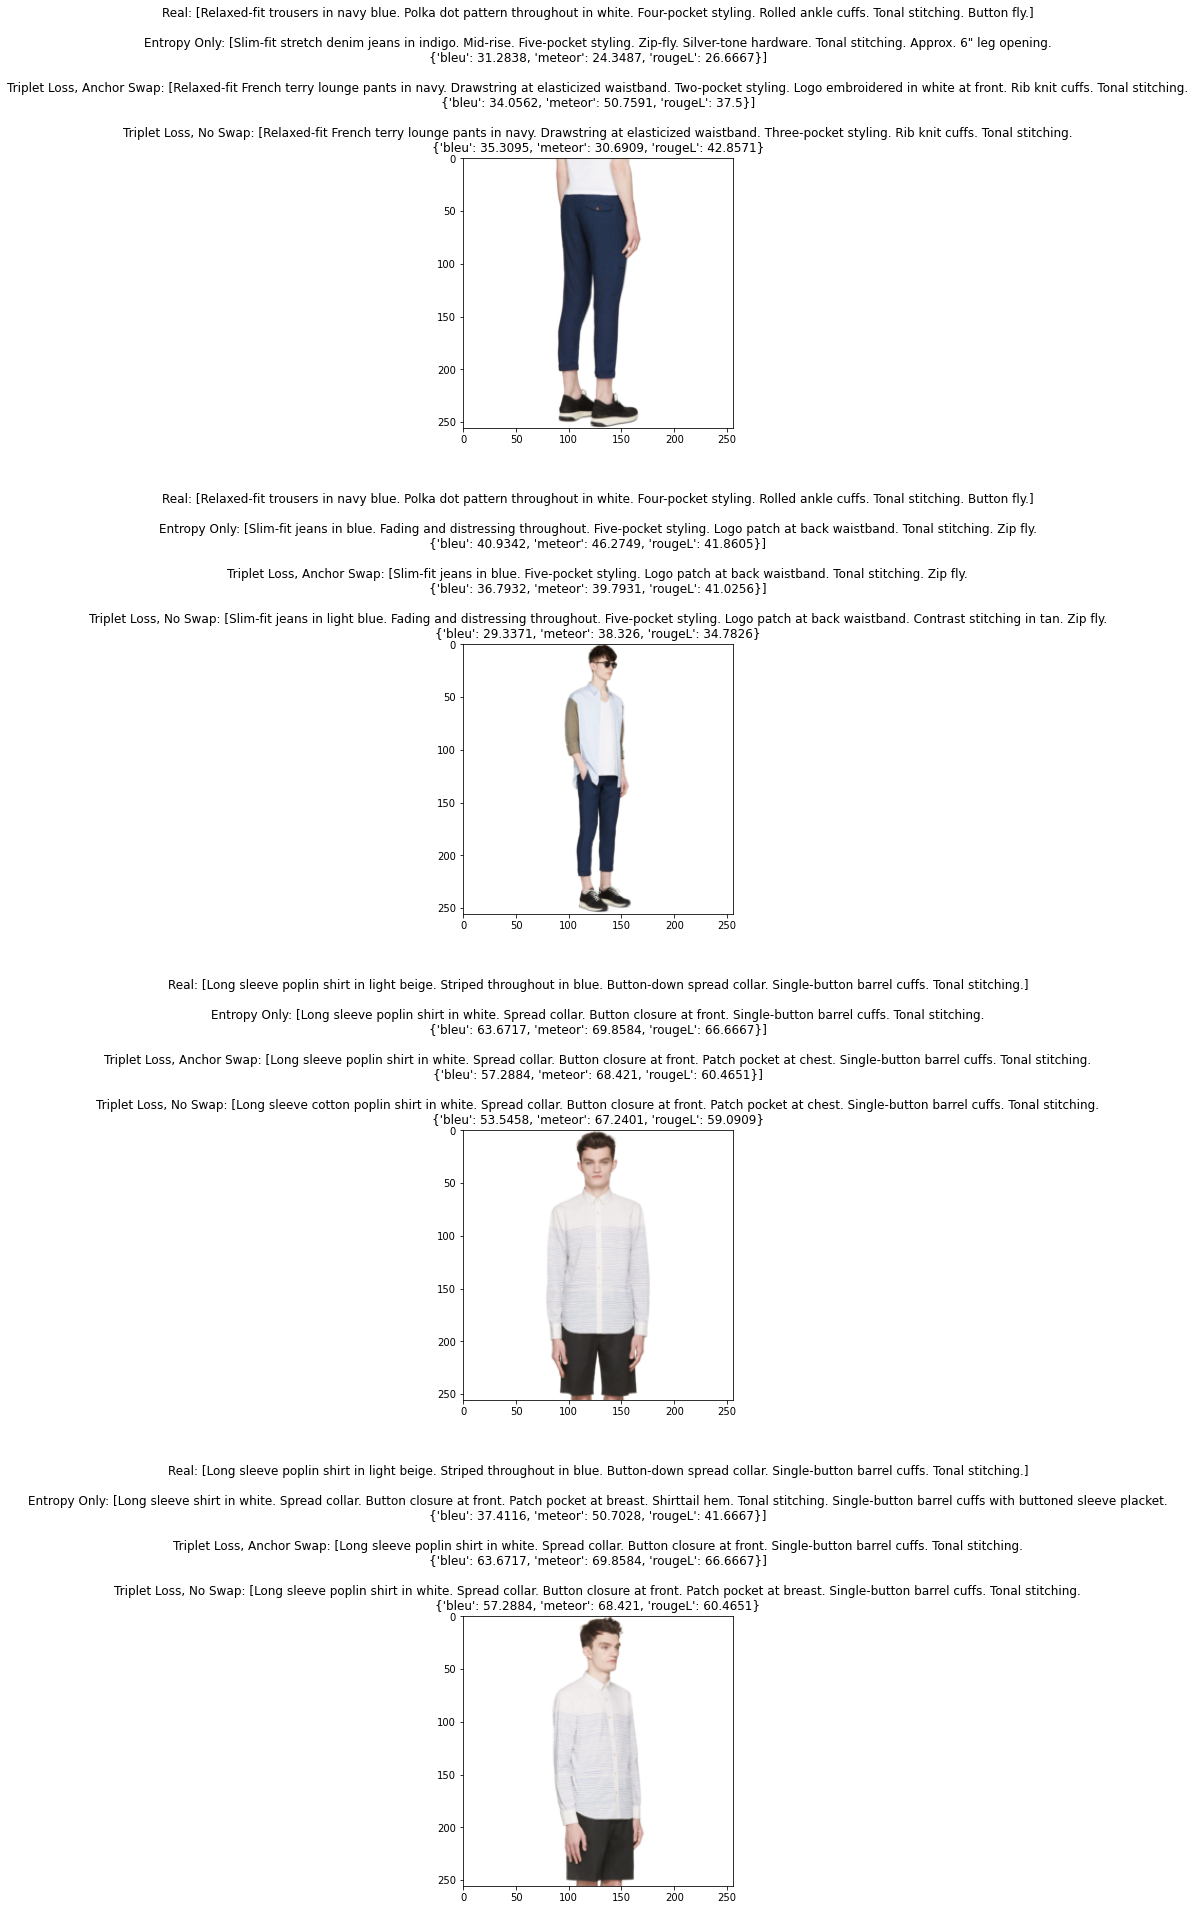

In [ ]:
# model.eval()
index = np.random.choice(range(0, len(data_val)-4))
real = torch.tensor([data_val[index]['labels'].numpy(), data_val[index+1]['labels'].numpy(), data_val[index+2]['labels'].numpy(), data_val[index+3]['labels'].numpy()])
sample = torch.tensor([data_val[index]['pixel_values'].numpy(), data_val[index+1]['pixel_values'].numpy(), data_val[index+2]['pixel_values'].numpy(), data_val[index+3]['pixel_values'].numpy()])
res = test_on_data_sample(model_basic, model_swap, model_noswap, index, real, sample)
figure, axis = plt.subplots(4, 1, figsize=(20, 30))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)
for i in range(0,4):
  axis[i].imshow(img_val[res['index']+i])
  axis[i].set_title('Real: [' + str(res['real'][i]) + 
            ']\n\nEntropy Only: [' + str(res['pred_basic'][i]) +
            '\n' + str(res['metrics_basic'][i]) +
            ']\n\nTriplet Loss, Anchor Swap: [' + str(res['pred_swap'][i]) +
            '\n' + str(res['metrics_swap'][i]) +
            ']\n\nTriplet Loss, No Swap: [' + str(res['pred_noswap'][i]) +
            '\n' + str(res['metrics_noswap'][i]))

In [ ]:
data = load_predictions(load_metrics=True)
img_val = h5py.File(data_path + "fashiongen_256_256_validation.h5", mode='r')["input_image"]

100%|██████████| 32528/32528 [00:03<00:00, 9574.39it/s]


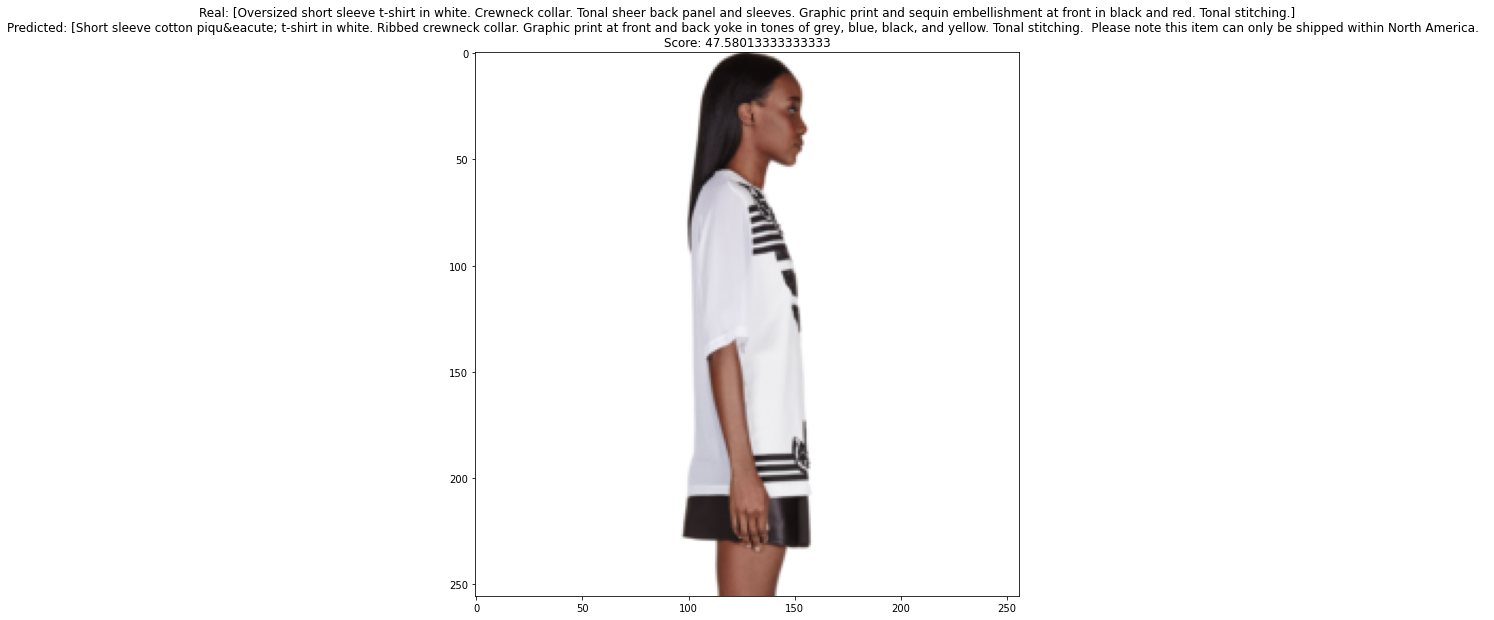

In [ ]:
index = np.random.choice(data[data.category == 'TOPS'].index)
plt.figure(figsize=(28, 10))
plt.imshow(img_val[index])
plt.title('Real: [' + str(data.real[index]) + 
          ']\nPredicted: [' + str(data.caption[index]) +
          '\nScore: ' + str(data.score[index]));

# Transformer Reinforcement Learning

In [ ]:
!pip install trl

In [ ]:
def get_response(model, pixel_values):
  return generate_caption(model=model, pixel_values=pixel_values)

def get_reward(real_caption, response):
  score = compute_metrics([[real_caption], [response]], decode=True)
  avg_score = sum(score.values()) / len(score)
  return avg_score

In [ ]:
# imports
from trl.ppo import PPOTrainer

checkpoint = checkpoints_path + 'VitGpt2-fashiongen-checkpoint-11000'
# get models
model_ref, tokenizer = init_model_and_data(vit_gpt2, checkpoint=checkpoint, init_data=False)
model_reinforced, tokenizer = init_model_and_data(vit_gpt2, checkpoint=checkpoint, init_data=False)
bert = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# initialize trainer
ppo_config = {'batch_size': 1, 'forward_batch_size': 1}
ppo_trainer = PPOTrainer(model_reinforced, model_ref, **ppo_config)

In [ ]:
def train_step(real_caption, pixel_values):
  # define a reward for response
  # (this could be any reward such as human feedback or output from another model)
  response = get_response(model_reinforced, pixel_values)
  reward = get_reward(real_caption, response)

  query = tokenizer.decode(real_caption, skip_special_tokens=True)
  query = torch.tensor(bert_tokenizer.encode(query))
  query = bert(torch.unsqueeze(query, 0))['pooler_output'].to(device)
  pixel_values = model_ref.encoder(torch.unsqueeze(pixel_values, 0))['pooler_output'].to(device)

  # train model with ppo
  train_stats = ppo_trainer.step(query, pixel_values, reward)
  return train_stats

## Triplet-Loss Test

### Model and Data setup

In [ ]:
#checkpoint = checkpoints_path + 'VitGpt2-fashiongen-checkpoint-11000'
step = 1000
checkpoint = checkpoints_path + 'checkpoint-' + str(step)
model, tokenizer, data_train, data_val = init_model_and_data(vit_gpt2, checkpoint=checkpoint, n_train=-1, n_val=4000, subcategory=True)
bert = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = model.to(device)
bert = bert.to(device)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

100%|██████████| 32528/32528 [00:35<00:00, 911.55it/s] 
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

### Tensorboard Monitoring

In [ ]:
tensorboard_path = './'+drive_path+'tensorboard/'
log_path = tensorboard_path+"swap_from_scratch_subcat_altnorm_lowmargin"

In [ ]:
writer = SummaryWriter(log_dir=log_path)
%load_ext tensorboard
%tensorboard --logdir $tensorboard_path

### Loss and Trainer config

In [ ]:
def normalize_0_to_1(x:torch.Tensor):
  # x -= x.min(1, keepdim=True)[0]
  # x /= x.max(1, keepdim=True)[0]
  # writer.add_text('tensor_shape', str(list(x.shape)))
  return torch.nn.functional.normalize(x, dim=1)

def get_bert_embedding(text, normalize:bool=True, decode:bool=True):
  if(decode):
    text = tokenizer.batch_decode(text, skip_special_tokens=True)
  input_ids = bert_tokenizer(text, truncation=True, max_length=64, padding='max_length', return_tensors='pt')['input_ids'].to(device)
  with torch.no_grad():
    embedding = bert(input_ids)['pooler_output']
  embedding.requires_grad
  return normalize_0_to_1(embedding) if normalize else embedding

def get_encoder_embedding(pixel_values, normalize:bool=True):
  embedding = model.encoder(pixel_values.to(device))['pooler_output']
  return normalize_0_to_1(embedding) if normalize else embedding

In [ ]:
def triplet_margin_loss(pixel_values, negatives, swap:bool=True):
    negative_embeddings = get_encoder_embedding(negatives)
    positive_embeddings = get_encoder_embedding(pixel_values)
    captions = generate_caption(model, pixel_values)
    caption_embeddings = get_bert_embedding(captions)
    return torch.nn.functional.triplet_margin_loss(anchor=caption_embeddings, positive=positive_embeddings, negative=negative_embeddings, margin=0.1, swap=swap)

### CustomLossTrainer

In [ ]:
class CustomLossTrainer(CustomTrainer):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.step = step

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        Subclass and override for custom behavior.
        """
        negative = inputs.pop("negative")
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            entropy_loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            entropy_loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
          
        triplet_loss = triplet_margin_loss(inputs["pixel_values"], negative)
        final_loss = entropy_loss + triplet_loss

        writer.add_scalar("Loss/train/triplet", triplet_loss, self.step)
        writer.add_scalar("Loss/train/entropy", entropy_loss, self.step)
        writer.add_scalar("Loss/train/final", final_loss, self.step)
        self.step += 1

        return (final_loss, outputs) if return_outputs else final_loss

      

In [ ]:
training_args = Seq2SeqTrainingArguments(
    dataloader_pin_memory = not device.type == 'cuda',
    per_device_train_batch_size = batch_size,   # batch size per device during training
    per_device_eval_batch_size = batch_size,    # batch size for evaluation
    output_dir = checkpoints_path,    # output directory
    overwrite_output_dir = False,
    load_best_model_at_end = False,
    predict_with_generate = True,
    generation_num_beams = 3, 
    eval_accumulation_steps = 500,  # send logits and labels to cpu for evaluation step by step, rather than all together
    evaluation_strategy = 'steps',
    save_strategy = 'steps',
    # save_total_limit = 1,   # Only last [save_total_limit] models are saved. Older ones are deleted.
    save_steps = 250,
    eval_steps = 11000,    # Evaluation and Save happens every [eval_steps] steps
    learning_rate = 5e-5,
    num_train_epochs = 1,    # total number of training epochs
    warmup_steps = 500,   # number of warmup steps for learning rate scheduler
    weight_decay = 0.01    # strength of weight decay
)

trainer = CustomLossTrainer(
    compute_metrics = compute_metrics,
    generation_function = generate_caption,
    tokenizer = None,
    data_collator = None,
    model = model, # the instantiated 🤗 Transformers model to be trained
    args = training_args,   # training arguments, defined above
    train_dataset = data_train,   # training dataset
    eval_dataset = data_val   # evaluation dataset
)

### Training sessions

In [ ]:
# qui c'era swap=True
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_category dictionary...


100%|██████████| 260490/260490 [04:32<00:00, 956.58it/s] 


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-500).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 500
  Will skip the first 0 epochs then the first 500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/500 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:31<00:00, 960.74it/s] 


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin


In [ ]:
# qui c'era swap=False
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_category dictionary...


100%|██████████| 260490/260490 [04:58<00:00, 872.38it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/pytorch_model.bin


Step,Training Loss,Validation Loss


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-500).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 500
  Will skip the first 0 epochs then the first 500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/500 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:54<00:00, 885.56it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/noswap-checkpoint-1000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 1000
  Will skip the first 0 epochs then the first 1000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1000 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:45<00:00, 911.66it/s]


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/pytorch_model.bin


In [ ]:
# entropy only no swap
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_category dictionary...


100%|██████████| 260490/260490 [04:35<00:00, 945.30it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/pytorch_model.bin


Step,Training Loss,Validation Loss


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-750).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 750
  Will skip the first 0 epochs then the first 750 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/750 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:53<00:00, 887.02it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/pytorch_model.bin


In [ ]:
# entropy only with swap
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_category dictionary...


100%|██████████| 260490/260490 [05:08<00:00, 844.68it/s] 


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to drive/

### Validation sessions

In [ ]:
# entropy only
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_category dictionary...


100%|██████████| 260490/260490 [04:29<00:00, 966.47it/s] 


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
1,No log,1.485807,41.869300,47.400300,46.688000


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


In [ ]:
# swap
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/swap-checkpoint-1000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 1000
  Will skip the first 0 epochs then the first 1000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1000 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:45<00:00, 912.38it/s]


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
1001,1.850900,1.654482,39.070400,43.900600,42.304800


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


In [ ]:
# no swap
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/noswap-checkpoint-1250).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 1250
  Will skip the first 0 epochs then the first 1250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1250 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:46<00:00, 909.89it/s] 


Step,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
1251,1.679600,1.485524,37.773500,41.264800,39.198300


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


In [ ]:
pd.DataFrame({'Bleu':[41.869300, 39.070400, 37.773500],'Meteor':[47.400300, 43.900600, 41.264800],'RougeL':[46.688000, 42.304800, 39.198300]},
             index=['Cross Entropy','Entropy + Triplet with Anchor swap','Entropy + Triplet'])

,Bleu,Meteor,RougeL
Cross Entropy,41.8693,47.4003,46.6880
Entropy + Triplet with Anchor swap,39.0704,43.9006,42.3048
Entropy + Triplet,37.7735,41.2648,39.1983


In [ ]:
# con swap, ma partendo da 0 (no checkpoints)
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_category dictionary...


100%|██████████| 260490/260490 [04:43<00:00, 917.82it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-1250).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 1250
  Will skip the first 0 epochs then the first 1250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1250 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:47<00:00, 905.64it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2250/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-2250).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 2250
  Will skip the first 0 epochs then the first 2250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/2250 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:56<00:00, 878.71it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3250/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3500/config.json


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-3500).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 3500
  Will skip the first 0 epochs then the first 3500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/3500 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:41<00:00, 926.67it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4500/pytorch_model.bin


Step,Training Loss,Validation Loss


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-4500).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 4500
  Will skip the first 0 epochs then the first 4500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/4500 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:45<00:00, 913.48it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5500/pytorch_model.bin


Step,Training Loss,Validation Loss


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-5250).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 5250
  Will skip the first 0 epochs then the first 5250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/5250 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [05:01<00:00, 862.66it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5500/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-5750).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 5750
  Will skip the first 0 epochs then the first 5750 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/5750 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:37<00:00, 939.29it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6500/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6750/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-6750).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 6750
  Will skip the first 0 epochs then the first 6750 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/6750 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:47<00:00, 906.64it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-7000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-7250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-7500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-7750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7750/pytorch_model.bin
Saving model checkpoint 

In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-8750).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 8750
  Will skip the first 0 epochs then the first 8750 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/8750 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [05:01<00:00, 863.34it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-9000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-9250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-9500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9500/pytorch_model.bin


Step,Training Loss,Validation Loss


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-9500).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 9500
  Will skip the first 0 epochs then the first 9500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/9500 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:49<00:00, 899.64it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-9750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9750/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


Step,Training Loss,Validation Loss


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-9750).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 9750
  Will skip the first 0 epochs then the first 9750 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/9750 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:35<00:00, 945.16it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-10000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10000/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-10250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-10500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10500/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-10500).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 10500
  Will skip the first 0 epochs then the first 10500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/10500 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:34<00:00, 949.89it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-10750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-10750/pytorch_model.bin


Step,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-10750).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 10750
  Will skip the first 0 epochs then the first 10750 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/10750 [00:00<?, ?it/s]

Creating input_category dictionary...


100%|██████████| 260490/260490 [04:43<00:00, 918.97it/s] 


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
11000,1.877000,1.125323,24.741000,33.566400,25.198800


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-11000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-11000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-11000/pytorch_model.bin


In [ ]:
# swap from scratch from subcat
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:04<00:00, 1063.58it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-250).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 250
  Will skip the first 0 epochs then the first 250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/250 [00:00<?, ?it/s]

Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:35<00:00, 946.10it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/pytorch_model.bin


In [ ]:
# learning rate 5e-5 -> 2e-5
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-1250).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 1250
  Will skip the first 0 epochs then the first 1250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1250 [00:00<?, ?it/s]

Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [05:00<00:00, 865.74it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2250/pytorch_model.bin
Saving model checkpoint 

Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3500/pytorch_model.bin


In [ ]:
# learning rate 2e-5 -> 5e-5
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-3250).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 3250
  Will skip the first 0 epochs then the first 3250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/3250 [00:00<?, ?it/s]

Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:24<00:00, 986.07it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4000/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-4000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 4000
  Will skip the first 0 epochs then the first 4000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/4000 [00:00<?, ?it/s]

Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:44<00:00, 916.23it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4500/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5000/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-5000).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 5000
  Will skip the first 0 epochs then the first 5000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/5000 [00:00<?, ?it/s]

Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:39<00:00, 932.13it/s] 


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5250/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5500/config.json
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6500
Configuration saved in drive/MyDrive/T

In [ ]:
# eval
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-6500).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 6500
  Will skip the first 0 epochs then the first 6500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/6500 [00:00<?, ?it/s]

Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:49<00:00, 898.30it/s]


Step,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
6501,2.003500,1.198661,18.503200,23.683000,18.055300


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


In [ ]:
trainer.train(checkpoint)
writer.flush()

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-6500).
***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 6500
  Will skip the first 0 epochs then the first 6500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/6500 [00:00<?, ?it/s]

Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:54<00:00, 883.72it/s]


Step,Training Loss,Validation Loss


In [ ]:
# norm dim=1
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:38<00:00, 934.70it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1250/pytorch_model.bin


In [ ]:
# norm dim=1, margin=0.1
trainer.train()
writer.flush()

***** Running training *****
  Num examples = 260490
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32562


Creating input_subcategory dictionary...


100%|██████████| 260490/260490 [04:53<00:00, 887.99it/s]


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-250/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-500/pytorch_model.bin


Step,Training Loss,Validation Loss


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/pytorch_model.bin
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin


In [ ]:
trainer.train(checkpoint)
writer.flush()